In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)   
    return device

def save_trained_model(model, filename):
    """
    保存训练好的模型到与ipynb文件相同路径下。
    
    参数：
    model (torch.nn.Module): 训练好的模型
    filename (str): 希望保存的文件名，包含后缀名（例如：'model.pth'）
    """
    # 将模型保存到指定路径
    torch.save(model.state_dict(), filename)
    print(f"模型已成功保存到 {filename}")
    
def load_trained_model(model_class, filename):
    """
    根据文件名读取模型并加载到内存中。
    
    参数：
    model_class (type): 模型的类，用于实例化一个模型对象
    filename (str): 保存的模型文件名，包含后缀名（例如：'model.pth'）
    
    返回：
    model (torch.nn.Module): 加载了权重的模型
    """
    # 实例化模型对象
    model = model_class()
    # 加载模型权重
    model.load_state_dict(torch.load(filename))
    print(f"模型已成功从 {filename} 加载")
    return model


# tagging origin

In [2]:
import itertools
import logging
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
from typing import List
import time
from conllu import parse
logging.basicConfig(level=logging.INFO)

DATA_PATH = "../data/"


# Format de sortie décrit dans
# https://pypi.org/project/conllu/

class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement s'il n'est pas connu
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    OOVID = 1
    PAD = 0

    def __init__(self, oov: bool):
        """ oov : autorise ou non les mots OOV """
        self.oov =  oov
        self.id2word = [ "PAD"]
        self.word2id = { "PAD" : Vocabulary.PAD}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self,idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self,idx: List[int]):
        return [self.getword(i) for i in idx]



class TaggingDataset():
    def __init__(self, data, words: Vocabulary, tags: Vocabulary, adding=True):
        self.sentences = []

        for s in data:
            self.sentences.append(([words.get(token["form"], adding) for token in s], [tags.get(token["upostag"], adding) for token in s]))
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, ix):
        return self.sentences[ix]


def collate_fn(batch):
    """Collate using pad_sequence"""
    return tuple(pad_sequence([torch.LongTensor(b[j]) for b in batch]) for j in range(2))


logging.info("Loading datasets...")
words = Vocabulary(True)
tags = Vocabulary(False)

#data_file = open(DATA_PATH+"fr_gsd-ud-train.conllu")
data_file = open(DATA_PATH+"fr_gsd-ud-train.conllu", encoding='utf-8')
raw_train = [parse(x)[0] for x in data_file if len(x)>1]
print('fr_gsd-ud-train.conllu-done')
data_file = open(DATA_PATH+"fr_gsd-ud-dev.conllu", encoding='utf-8')
raw_dev = [parse(x)[0] for x in data_file if len(x)>1]
print('fr_gsd-ud-dev.conllu-done')
data_file = open(DATA_PATH+"fr_gsd-ud-test.conllu", encoding='utf-8')
raw_test = [parse(x)[0] for x in data_file if len(x)>1]
print('fr_gsd-ud-test.conllu-done')
train_data = TaggingDataset(raw_train, words, tags, True)
dev_data = TaggingDataset(raw_dev, words, tags, True)
test_data = TaggingDataset(raw_test, words, tags, False)


logging.info("Vocabulary size: %d", len(words))


BATCH_SIZE=100

train_loader = DataLoader(train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
#大概要15秒#在加载数据的时候已经使用了padding，运算的时候输入的是延长过的
#  TODO:  Implémenter le modèle et la boucle d'apprentissage (en utilisant les LSTMs de pytorch)


INFO:root:Loading datasets...


fr_gsd-ud-train.conllu-done
fr_gsd-ud-dev.conllu-done
fr_gsd-ud-test.conllu-done


INFO:root:Vocabulary size: 44939


数据测试

In [3]:
max_x=[];max_y=[]
for x, y in train_loader:
    print(x.size(), y.size())
    print(x.max(), y.max())
    max_x.append(x.max())
    max_y.append(y.max())
    #token_visible=[tags.getword(i) for i in y]
    #print(token_visible)
    break    
print(max(max_x))
print(max(max_y))
# tensor(42343)
# tensor(17）
#predicted_tag_names = [tags.getword(tag) for tag in predicted_tags]

torch.Size([1, 100]) torch.Size([1, 100])
tensor(40950) tensor(16)
tensor(40950)
tensor(16)


In [4]:
# 选择一个批次进行测试
for tokens, tags in train_loader:
    # 打印批次的基本信息
    print("Tokens Shape:", tokens.shape)  # 应该是 (batch_size, seq_length)
    print("Tags Shape:", tags.shape)      # 应该是 (batch_size, seq_length)
    
    # 获取批次长度（假设 tokens 是填充的张量，获取每个序列的实际长度）
    #lengths = (tokens != 0).sum(dim=1)  # 计算每个序列的实际长度，忽略填充值 0
    # 使用模型进行前向传播
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 前向传播不需要计算梯度
        tag_scores = model(tokens)  # 预测标签
        
    # 打印预测结果
    print("Tag Scores Shape:", tag_scores.shape)  # 输出应为 (batch_size, seq_length, tagset_size)
    print("Sample Tag Scores (First Sequence):", tag_scores[0])  # 打印第一个样本的预测结果

    # 测试完成后直接跳出循环
    break


Tokens Shape: torch.Size([1, 100])
Tags Shape: torch.Size([1, 100])


NameError: name 'model' is not defined

# question 1  
序列到序列（seq2seq） 模型，用于词性标注（POS Tagging）任务。   
处理未登录词（OOV），并对模型的结果进行可视化 
// 
实现 LSTM 模型和训练循环，并使用填充技术来处理不同长度的输入。
实现未登录词替换机制，用于增强模型在测试时的泛化能力。
可视化模型的标注结果，即为输入句子输出相应的词性标签。
//

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
#pack_padded_sequence:已经填充的序列（padded sequence）-->紧凑表示的 打包序列（PackedSequence），
# 这样在递归神经网络中只计算有效的部分，而不会浪费计算在填充的部分上。

# pad_packed_sequence:打包序列（PackedSequence） -->恢复为原来的填充形式（padded sequence），
# 即还原为一个具有相同长度的批次张量，方便后续处理。
#适用场景：在递归神经网络处理后，得到的输出通常是 PackedSequence 类型。
# 为了后续的全连接层或其他处理步骤，可将其还原为填充的张量，这时候就用到 pad_packed_sequence。


# 模型定义
class POSTagger(nn.Module):#这里embedding的传入维度到底得是多少啊？
    #dic好像是42343
    def __init__(self, dictionary_size, tagset_size, embedding_dim, hidden_dim):
        super(POSTagger, self).__init__()
        self.embedding = nn.Embedding(dictionary_size+1, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)# 批次大小（batch_size） 是第一个维度。
        #（batch_size,sequence_length,feature_dimension）
        self.fc = nn.Linear(hidden_dim, tagset_size+1)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        # output：LSTM 所有时间步的输出。
        # (h_n, c_n)：LSTM 的最终隐藏状态和细胞状态。这俩是
        # 元组，每个都是(num_layers * num_directions, batch, hidden_size)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        logits = self.fc(output)
        return logits
    
# OOV 处理：随机替换训练数据中的一些词为 [OOV]
def add_oov_tokens(dataset, oov_token_id, oov_probability=0.1):
    for tokens, tags in dataset:
        for i in range(len(tokens)):
            if torch.rand(1).item() < oov_probability:
                tokens[i] = oov_token_id

# 模型训练
from tqdm import tqdm
def train_model(model, train_loader, criterion, optimizer,device, num_epochs=5):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        time_epoch=0
        for tokens, tags in tqdm(train_loader):
            tokens = tokens.to(device)
            tags = tags.to(device)
            time_epoch+=1
            lengths = [len(s) for s in tokens] 
            #print(tokens.size(), tags.size())
            #both 1*100
            optimizer.zero_grad()
            tag_scores = model(tokens,lengths)# 1*100*17
            #tag_scores_ = tag_scores.view(-1, tag_scores.shape[-1])
            tag_scores_ = tag_scores.squeeze(0)
            #tags_1 = tags.view(-1)#100*17            
            try:
                loss = criterion(tag_scores_, tags.squeeze(0))
            except:
                print(tags.squeeze(0).size(),tags.squeeze(0).max())
            loss.backward()
            optimizer.step()
            #print(time_epoch)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    return model

# 示例使用
vocab_size = 42343  # 假设词汇表大小
tagset_size = 17 # 假设有10种不同的词性标签
embedding_dim = 128
hidden_dim = 128

model = POSTagger(vocab_size, tagset_size, embedding_dim, hidden_dim)
#criterion = nn.CrossEntropyLoss(ignore_index=-1)
criterion = nn.CrossEntropyLoss(ignore_index=Vocabulary.PAD)

optimizer = optim.Adam(model.parameters())
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device='cpu'
model.to(device)
criterion.to(device)

cuda


CrossEntropyLoss()

In [5]:
#训练
model=train_model(model, train_loader, criterion, optimizer,device,num_epochs=10)

100%|██████████| 3932/3932 [01:26<00:00, 45.28it/s]


Epoch 1/10, Loss: 0.3983815312385559


100%|██████████| 3932/3932 [01:54<00:00, 34.30it/s]


Epoch 2/10, Loss: 0.29941675066947937


100%|██████████| 3932/3932 [02:00<00:00, 32.70it/s]


Epoch 3/10, Loss: 0.30631986260414124


100%|██████████| 3932/3932 [02:01<00:00, 32.44it/s]


Epoch 4/10, Loss: 0.13289403915405273


100%|██████████| 3932/3932 [02:01<00:00, 32.41it/s]


Epoch 5/10, Loss: 0.1647188514471054


100%|██████████| 3932/3932 [01:28<00:00, 44.53it/s]


Epoch 6/10, Loss: 0.19916103780269623


100%|██████████| 3932/3932 [01:24<00:00, 46.62it/s]


Epoch 7/10, Loss: 0.07554765045642853


100%|██████████| 3932/3932 [01:46<00:00, 36.91it/s]


Epoch 8/10, Loss: 0.07914081960916519


100%|██████████| 3932/3932 [01:45<00:00, 37.31it/s]


Epoch 9/10, Loss: 0.16812053322792053


100%|██████████| 3932/3932 [01:48<00:00, 36.24it/s]

Epoch 10/10, Loss: 0.10522463917732239


word测试

In [20]:
def test_vocabulary():
    # 创建一个允许 OOV 处理的词汇表
    words = Vocabulary(oov=True)
    
    # 1. 测试基本映射功能
    assert words.get("hello") == 2, "Failed to add 'hello' correctly to vocabulary"
    assert words.get("world") == 3, "Failed to add 'world' correctly to vocabulary"
    assert words.get("hello") == 2, "'hello' should have consistent index"

    print("Basic mapping test passed.")

    # 2. 测试 OOV 处理
    oov_id = words["__OOV__"]
    assert words["unknown_word"] == oov_id, "Failed to map unknown word to OOV"
    
    print("OOV handling test passed.")

    # 3. 测试词汇表扩展功能
    new_word_id = words.get("new_word", adding=True)
    assert new_word_id == 4, "Failed to add 'new_word' correctly to vocabulary"
    assert words.get("new_word") == new_word_id, "'new_word' should have consistent index"

    print("Vocabulary extension test passed.")

    # 4. 测试索引到单词的映射
    assert words.getword(2) == "hello", "Failed to retrieve word by index for 'hello'"
    assert words.getword(1) == "__OOV__", "Failed to retrieve OOV by index"
    assert words.getword(0) == "PAD", "Failed to retrieve PAD by index"

    print("Index to word mapping test passed.")

    # 5. 测试边界情况
    # 重复添加单词
    assert words.get("hello") == 2, "'hello' should remain consistent after repeated addition"
    
    # 查询不存在且未启用添加的新单词
    try:
        words.get("not_in_vocab", adding=False)
    except KeyError:
        print("Correctly raised KeyError for non-existing word when adding=False.")
    else:
        print("Failed to raise KeyError for non-existing word.")

    print("Boundary case test passed.")

    print("All tests passed.")

# 运行测试函数
test_vocabulary()


Basic mapping test passed.
OOV handling test passed.
Vocabulary extension test passed.
Index to word mapping test passed.
Failed to raise KeyError for non-existing word.
Boundary case test passed.
All tests passed.


In [11]:
# 假设已经训练好的模型对象为 model
# 词汇表对象为 words
# 输入示例句子为 sample_sentence

# 可视化模型结果
import copy
def visualize_predictions(model, sample_sentence, vocab, tags):
    model = copy.deepcopy(model).to('cpu')  
    model.eval()
    with torch.no_grad():
        tokens = []
        for word in sample_sentence.split():
            try:
                # 使用 vocab.get(word, adding=False) 来获取索引
                token_id = vocab.get(word, adding=False)
            except KeyError:
                # 打印提示信息，但继续进行预测，处理未登录词
                print(f"Warning: Word '{word}' not found in vocabulary and adding is not allowed.")
                token_id = Vocabulary.OOVID
            tokens.append(token_id)

        # 将 tokens 列表转换为张量，并移动到指定设备上
        tokens_tensor = torch.tensor(tokens).unsqueeze(0).to('cpu')    # 添加批次维度，形状为 (1, seq_length)

        # 获取输入序列的长度，并确保它在 CPU 上
        lengths = torch.tensor([len(tokens)], dtype=torch.int64).cpu()

        # 使用模型进行前向传播预测标签
        tag_scores = model(tokens_tensor.to('cpu')  , lengths)

        # 获取每个时间步上得分最高的标签索引
        _, predicted_tags = torch.max(tag_scores, dim=2)
        predicted_tags = predicted_tags.squeeze().tolist()

        # 将预测的标签索引转换为对应的标签名称
        predicted_tag_names = [tags.getword(tag) for tag in predicted_tags]

        # 打印输入句子和对应的预测标签
        print("Input Sentence:", sample_sentence)
        print("Predicted Tags (Indices):", predicted_tags)
        print("Predicted Tags (Names):", predicted_tag_names)

sample_sentence = "i have a pen"
# 调用 visualize_predictions 函数
visualize_predictions(model, sample_sentence, words,tags)


Input Sentence: i have a pen
Predicted Tags (Indices): [16, 12, 4, 12]
Predicted Tags (Names): ['X', 'PROPN', 'AUX', 'PROPN']


In [12]:
for idx in range(len(tags)):
    print(f"Index: {idx}, Tag: {tags.getword(idx)}")


Index: 0, Tag: PAD
Index: 1, Tag: DET
Index: 2, Tag: NOUN
Index: 3, Tag: ADJ
Index: 4, Tag: AUX
Index: 5, Tag: VERB
Index: 6, Tag: ADV
Index: 7, Tag: ADP
Index: 8, Tag: SCONJ
Index: 9, Tag: PRON
Index: 10, Tag: PUNCT
Index: 11, Tag: _
Index: 12, Tag: PROPN
Index: 13, Tag: CCONJ
Index: 14, Tag: NUM
Index: 15, Tag: SYM
Index: 16, Tag: X
Index: 17, Tag: INTJ


截图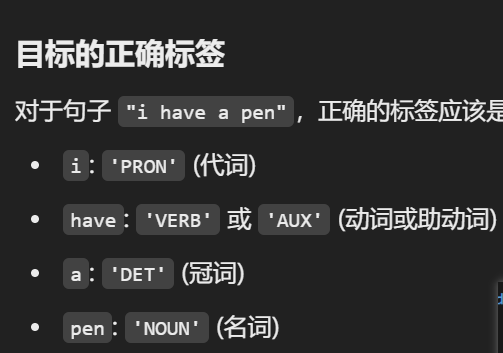

# question2  
用tp5 traduction  
编码：embedding+GRU  
解码：embedding+GRU+linear+softmax   
在解码器中，需要实现一个 generate(hidden, lenseq=None) 方法，  
输入为隐状态 hidden（以及开始 token SOS），用于生成目标句子，直到达到给定长度 lenseq 或遇到结束 token EOS。  


## traduction.py

包的导入与SummaryWriter

In [2]:
import logging
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import unicodedata
import string
from tqdm import tqdm
from pathlib import Path
from typing import List
import time
import re
from torch.utils.tensorboard import SummaryWriter
import os

# 格式化时间并替换不合法的字符
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")  # 格式为 "2024-10-22_21-32-34"
log_dir = f"/tmp/runs/tag-{timestamp}"

logging的解释  
logging 模块提供了记录日志的功能，可以用来捕捉程序的状态、错误、警告以及调试信息。  
相比于print()，它更灵活，尤其在大型应用程序中，可以方便地记录、过滤和分类日志信息。  

1、分级：
DEBUG：最低级别，详细的信息，通常只在诊断问题时使用。  
INFO：一般的信息，表示程序正常运行的状态。  
WARNING：警告信息，表明有些问题，但并不影响程序的正常运行。  
ERROR：错误信息，表明发生了较严重的问题，程序的一部分功能可能无法继续执行。  
CRITICAL：最严重的错误，表明程序遇到严重的错误，可能需要立即处理。   

2、logging.basicConfig() 函数的作用   
配置日志记录的基本设置：basicConfig() 函数用于设置日志记录的基本配置，比如日志级别、日志格式、输出文件等。  
level=logging.INFO：这个参数指定了日志的级别为 INFO。这意味着：  
只会记录 INFO 及更高级别（即 INFO, WARNING, ERROR, CRITICAL）的日志信息。  
DEBUG 级别的信息将不会被记录，因为它的优先级低于 INFO。  

示例：
logging.basicConfig(level=logging.INFO)

#记录不同级别的日志
logging.debug("This is a debug message")  # 这个消息不会被记录，因为级别低于 INFO
logging.info("This is an info message")   # 这个消息会被记录
logging.warning("This is a warning message")  # 这个消息会被记录
logging.error("This is an error message")  # 这个消息会被记录
logging.critical("This is a critical message")  # 这个消息会被记录



In [4]:
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.INFO, filename='app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')

单词类 & 正规化函数  
单词类可以说完全是一个空白单词表，加入新的词汇需要将语料预先处理成单个的词语输入

In [5]:
def normalize(s):
    return re.sub(' +',' ', "".join(c if c in string.ascii_letters else " " #将字符串 s 转为小写，并移除字符串两端的空白字符。
         for c in unicodedata.normalize('NFD', s.lower().strip())
         if  c in string.ascii_letters+" "+string.punctuation)).strip()
#如果 c 是 ASCII 字母（A-Z, a-z），则保留原字符，否则用空格代替。


class Vocabulary:
    """Permet de gérer un vocabulaire.
    生成单词

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    PAD = 0
    EOS = 1
    SOS = 2
    OOVID = 3

    def __init__(self, oov: bool):
        self.oov = oov
        self.id2word = ["PAD", "EOS", "SOS"]
        self.word2id = {"PAD": Vocabulary.PAD, "EOS": Vocabulary.EOS, "SOS": Vocabulary.SOS}
        if oov:# 指定OOV参数
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):#word：输入的单词
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            #add：添加词
            #oov：当前词汇表不包含则返回oov
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid#添加一个新的词汇
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):#单词表有多少个单词
        return len(self.id2word)

    def getword(self, idx: int):#单个输出，只能搜有的
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self, idx: List[int]):
        return [self.getword(i) for i in idx]


定义tradDataset类 & 填充两个两种语言数据库
用于加载和处理翻译任务中的训练数据。将输入和目标语言的句子进行标准化与编码，并保存为张量。

In [7]:
class TradDataset():
    def __init__(self,data,vocOrig,vocDest,adding=True,max_len=10):
        """
        传入数据，数据用\t分割，第一列为源语言，第二列为目标语言
        """
        self.sentences =[]
        for s in tqdm(data.split("\n")):#逐行输入
            if len(s)<1:#跳过空行
                continue
            orig,dest=map(normalize,s.split("\t")[:2])
            #:2应该是去掉了数据源
            if len(orig)>max_len: #跳过过长
                continue
            self.sentences.append((
                torch.tensor([vocOrig.get(o) for o in orig.split(" ")]+[Vocabulary.EOS]),
                torch.tensor([vocDest.get(o) for o in dest.split(" ")]+[Vocabulary.EOS])
                ))
            #两个voc应该是Vocabulary的输入
    def __len__(self):#源句和目标句组成的元组列表
        return len(self.sentences) 
    def __getitem__(self,i): 
        return self.sentences[i]



def collate_fn(batch):
    orig,dest = zip(*batch)
    o_len = torch.tensor([len(o) for o in orig])
    d_len = torch.tensor([len(d) for d in dest])
    #返回的值是末尾填充0的结果
    #具体填充的之后的长度取决于单个数据集里面最大的那个
    return pad_sequence(orig),o_len,pad_sequence(dest),d_len
device = get_device()

cuda


读取数据
加载英语到法语的翻译数据集，将其分成训练集和测试集，  
数据集转换为 PyTorch 的数据加载器 (DataLoader) 格式

In [8]:
FILE = "../data/en-fra.txt"
with open(FILE, encoding='utf-8') as f:
    lines = f.readlines()


lines = [lines[x] for x in torch.randperm(len(lines))]
#先别打乱
#将输入的数据集打乱，随机排序
idxTrain = int(0.8*len(lines))
#80%训练
vocEng = Vocabulary(True)
vocFra = Vocabulary(True)
MAX_LEN=100
BATCH_SIZE=100

datatrain = TradDataset("".join(lines[:idxTrain]),vocEng,vocFra,max_len=MAX_LEN)
datatest = TradDataset("".join(lines[idxTrain:]),vocEng,vocFra,max_len=MAX_LEN)

train_loader = DataLoader(datatrain, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datatest, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 34132/34132 [00:01<00:00, 22546.47it/s]


打印一些数据集尝尝咸淡

In [15]:
# print(lines[:10])
# print(datatrain[0])
# print(vocEng.getwords([4, 5, 6, 7, 8, 9, 1]))
# print(vocFra.getwords([4, 5, 6, 7, 8, 9,10, 1]))
datatrain_mini_on_shuffle = TradDataset("".join(lines[:6]),vocEng,vocFra,max_len=MAX_LEN)
train_loader_no_shuffle = DataLoader(datatrain_mini_on_shuffle, collate_fn=collate_fn, batch_size=3,shuffle=False)
#batch_size for what, the x_tuple didnt change at all
print('len loader',len(train_loader_no_shuffle)) #n/2;lines[:n]
for i,x_tuple in enumerate(train_loader_no_shuffle):#tuples in it ,each tuple has 4 tensors
    print(f'{i+1}ere element')
    print(type(x_tuple))
    print(len(x_tuple))

print('tensor 1:',x_tuple[0].size())#total eng sentence 
for i in range(x_tuple[0].size()[1]):  #lines 的长度决定了有多少列，也就是下方每个循环能跑多少
    print(vocEng.getwords(x_tuple[0][:,i].tolist()))
    print(vocFra.getwords(x_tuple[0][:,i].tolist()))
    print('\n')
print('\n')
print('tensor 2',x_tuple[1].size())
print(vocEng.getwords(x_tuple[1].tolist()))
print(vocFra.getwords(x_tuple[1].tolist()))
print('\n')
print('tensor 3:',x_tuple[2].size())#total fr sentence 
for i in range(x_tuple[2].size()[1]):
    print(vocEng.getwords(x_tuple[2][:,i].tolist()))
    print(vocFra.getwords(x_tuple[2][:,i].tolist()))
    print('\n')
print('\n')
print('tensor 4',x_tuple[3].size())
print(vocEng.getwords(x_tuple[3].tolist()))
print(vocFra.getwords(x_tuple[3].tolist()))



100%|██████████| 7/7 [00:00<?, ?it/s]

len loader 2
1ere element
<class 'tuple'>
4
2ere element
<class 'tuple'>
4
tensor 1: torch.Size([7, 3])
['we', 'have', 'faith', 'in', 'tom', 'EOS', 'PAD']
['avons', 'table', 'foi', 'en', 'tom', 'EOS', 'PAD']


['we', 're', 'not', 'fit', 'EOS', 'PAD', 'PAD']
['avons', 'forme', 'j', 'ai', 'EOS', 'PAD', 'PAD']


['i', 'looked', 'all', 'over', 'for', 'tom', 'EOS']
['cherche', 'partout', 'je', 'sais', 'vivre', 'tom', 'EOS']




tensor 2 torch.Size([3])
['studying', 's', 'we']
['nous', 'etudie', 'avons']


tensor 3: torch.Size([7, 3])
['studying', 'we', 'faith', 'in', 'tom', 'EOS', 'PAD']
['nous', 'avons', 'foi', 'en', 'tom', 'EOS', 'PAD']


['studying', 'don', 'had', 'put', 'in', 're', 'EOS']
['nous', 'ne', 'sommes', 'pas', 'en', 'forme', 'EOS']


['not', 'fit', 'i', 'tom', 'looked', 'EOS', 'PAD']
['j', 'ai', 'cherche', 'tom', 'partout', 'EOS', 'PAD']




tensor 4 torch.Size([3])
['studying', 'we', 'studying']
['nous', 'avons', 'nous']


## 训练翻译器

编码解码器

In [11]:
class Encoder(nn.Module):
    """
    inputsize要注意是单词表的长度+1
    forward 的输出是所有阶段的隐藏状态，
    隐藏状态尺寸：（batch，lengths,hidden_size）
    """
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True)
        

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed_input)
        return hidden

class Decoder(nn.Module):
    """
    解码器的输入=目标语言已经生成的序列+编码器生成的hidden
    """
    def __init__(self, output_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        """hidden from encoder"""
        # input: [batch_size, 1] (当前时间步的单词，通常是单词索引)
        embedded = self.embedding(input)
        # 通过 GRU 进行解码，使用当前时间步的嵌入和前一个时间步的隐状态
        output, hidden = self.gru(embedded, hidden)
        
        # # 输出预测值 (用全连接层将 GRU 的输出转换为词汇表大小的向量)
        prediction = self.fc(output)
        return prediction, hidden


训练环节

In [16]:
import random

def train(encoder, decoder, dataloader, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    
    for src, src_len, tgt, tgt_len in dataloader:
        # Zero gradients
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        # Forward pass through encoder
        hidden = encoder(src, src_len)
        
        # Use the first token as input to decoder
        input = torch.tensor([[Vocabulary.SOS]], device=hidden.device)
        loss = 0
        teacher_forcing = random.random() < teacher_forcing_ratio
        
        if teacher_forcing:
            # Use teacher forcing
            for t in range(tgt.size(1)):
                output, hidden = decoder(input, hidden)
                loss += criterion(output, tgt[:, t])
                input = tgt[:, t].unsqueeze(1)
        else:
            # Use the decoder's own prediction
            for t in range(tgt.size(1)):
                output, hidden = decoder(input, hidden)
                loss += criterion(output, tgt[:, t])
                input = output.argmax(1).unsqueeze(1)
        
        # Backpropagate and update parameters
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

